In [1]:
from diffusers import ( 
    DiffusionPipeline,
    AutoencoderKL,
    StableDiffusionXLPipeline
)
from diffusers.utils import make_image_grid
import torch
import os
import glob
import numpy as np
from PIL import Image
from torchvision import transforms
from diffusers.utils.torch_utils import randn_tensor
import glob
import random
import itertools
from IPython.display import clear_output
from diffusers.utils.torch_utils import randn_tensor

negative_prompt = None
model_id = '/data/model/stable-diffusion-xl-base-1.0'
vae_id = '/data/model/sdxl-vae-fp16-fix'

device = 'cuda:0'
vae = AutoencoderKL.from_pretrained(vae_id, torch_dtype=torch.float16)
pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    vae=vae,
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16"
    )

pipe = pipe.to(device)

/data/sangwon/anaconda3/envs/mudi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


In [2]:
def bbox_mask(mask_image):
    """
    mask: PIL.Image

    return: list
    """
    # Convert the PIL image to a NumPy array
    mask = np.array(mask_image)

    # Apply a threshold to binarize the mask
    threshold_value = 128  # You might need to adjust this value
    mask_binary = (mask > threshold_value).astype(np.uint8) * 255
    
    # Find the bounding box of the non-zero regions in the binary mask
    rows = np.any(mask_binary, axis=1)
    cols = np.any(mask_binary, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # The bounding box is defined by the coordinates (xmin, ymin) and (xmax, ymax).
    bbox = (xmin, ymin, xmax, ymax)

    return bbox

def image_process(image, mask, margin=32, fixed_scale=None):
    """
    Crop the image and mask, based on the bbox of mask map.
    The resize width is 512, and there is an optional mergin.

    image: PIL.Image
    mask: PIL.Image
    """
    original_size = image.size[0]
    # image = image.resize((1024, 1024))
    # mask = mask.resize((1024, 1024))

    
    bbox = bbox_mask(mask)
    image = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
    mask = mask.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
    width, height = image.size

    if fixed_scale is not None:
        rescaling_factor = min((512 - margin) / width, (1024 - margin) / height) * fixed_scale 
        #(512 - margin) / width * fixed_scale
    else:
        max_factor = min((512 - margin) / width, (1024 - margin) / height)
        # rescaling_factor = np.random.uniform(0.75, max_factor)
        rescaling_factor = np.random.uniform(max_factor * 0.75, max_factor)

    # rescaling_factor = max_factor
    # print(rescaling_factor)
    
    # new_size = int(original_size * rescaling_factor)

    image = image.resize((int(width * rescaling_factor), int(height * rescaling_factor)))
    mask = mask.resize((int(width * rescaling_factor), int(height * rescaling_factor)))

    return image, mask 


def image_collage(image_0, mask_0, image_1, mask_1, white=False, margin_max=10, height_sync=False):
    rgb_back = 255 if white else 0
    background = np.zeros((1024, 1024, 3), dtype=np.uint8)
    mask_map = np.zeros((1024, 1024))

    if height_sync:
        y_max_sync = 1024 - max(image_0.size[1], image_1.size[1])
        y_sync = random.randint(0, y_max_sync)
        y_pos_0, y_pos_1 = y_sync, y_sync
    else:
        y_max_0 = 1024 - image_0.size[1]
        y_max_1 = 1024 - image_1.size[1]
        y_pos_0 = random.randint(0, y_max_0)
        y_pos_1 = random.randint(0, y_max_1)

    image_0 = np.array(image_0)
    binary_mask_0 = np.array(mask_0) > 122
    image_0[binary_mask_0 == 0] = 0 # background goes to 0

    image_1 = np.array(image_1)
    binary_mask_1 = np.array(mask_1) > 122
    image_1[binary_mask_1 == 0] = 0 
    
    # Determin which image goes on top
    is_left = True if random.random() < 0.5 else False

    # margin for x axis
    left_margin = random.randint(0, margin_max)
    right_margin = random.randint(0, margin_max)

    mask_map[y_pos_0:y_pos_0 + binary_mask_0.shape[0], left_margin:left_margin + binary_mask_0.shape[1]] += binary_mask_0
    mask_map[y_pos_1:y_pos_1 + binary_mask_1.shape[0], -right_margin - binary_mask_1.shape[1] -1:-right_margin-1] += binary_mask_1

    merged_mask_map = mask_map > 0
    union_mask_map = mask_map > 1.5

    if is_left:
        background[y_pos_0:y_pos_0 + image_0.shape[0], left_margin:left_margin + image_0.shape[1]] = image_0 
        background[union_mask_map] = 0
        background[y_pos_1:y_pos_1 + image_1.shape[0], -right_margin - image_1.shape[1] -1:-right_margin-1] += image_1 
    else:
        background[y_pos_1:y_pos_1 + image_1.shape[0], -right_margin - image_1.shape[1] -1:-right_margin-1] = image_1
        background[union_mask_map] = 0
        background[y_pos_0:y_pos_0 + image_0.shape[0], left_margin:left_margin + image_0.shape[1]] += image_0 
    
    if white:
        background[merged_mask_map == 0] = 255

    return background, merged_mask_map
    

In [3]:
from functools import partial

def get_timesteps(self, num_inference_steps, strength, device, denoising_start=None):
    # get the original timestep using init_timestep
    if denoising_start is None:
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
        t_start = max(num_inference_steps - init_timestep, 0)
    else:
        t_start = 0

    timesteps = self.scheduler.timesteps[t_start * self.scheduler.order :]

    # Strength is irrelevant if we directly request a timestep to start at;
    # that is, strength is determined by the denoising_start instead.
    if denoising_start is not None:
        discrete_timestep_cutoff = int(
            round(
                self.scheduler.config.num_train_timesteps
                - (denoising_start * self.scheduler.config.num_train_timesteps)
            )
        )

        num_inference_steps = (timesteps < discrete_timestep_cutoff).sum().item()
        if self.scheduler.order == 2 and num_inference_steps % 2 == 0:
            # if the scheduler is a 2nd order scheduler we might have to do +1
            # because `num_inference_steps` might be even given that every timestep
            # (except the highest one) is duplicated. If `num_inference_steps` is even it would
            # mean that we cut the timesteps in the middle of the denoising step
            # (between 1st and 2nd devirative) which leads to incorrect results. By adding 1
            # we ensure that the denoising process always ends after the 2nd derivate step of the scheduler
            num_inference_steps = num_inference_steps + 1

        # because t_n+1 >= t_n, we slice the timesteps starting from the end
        timesteps = timesteps[-num_inference_steps:]
        return timesteps, num_inference_steps

    return timesteps, num_inference_steps - t_start

def add_noise(pipe, latents, strength=1.0, noise=None):
    # if pipe has no get_timesteps method
    if not hasattr(pipe, 'get_timesteps'):
        pipe.get_timesteps = partial(get_timesteps, pipe)
    
    num_inference_steps = 50
    device = latents.device
    noise = randn_tensor(latents.shape, device=device, dtype=latents.dtype) if noise is None else noise
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps, _ = pipe.get_timesteps(
        num_inference_steps,
        strength,
        device,
        denoising_start=None,
    )
    latent_timestep = timesteps[:1]
    # scaled_latents = latents * pipe.vae.config.scaling_factor
    return pipe.scheduler.add_noise(latents, noise, latent_timestep)

In [4]:
image_0 = Image.open('dataset/category/actionfigure_2_and_dog0/a02.jpg')
image_1 = Image.open('dataset/category/actionfigure_2_and_dog0/b01.jpg')

mask_0 = Image.open('dataset/category/actionfigure_2_and_dog0/mask_a02.jpg')
mask_1 = Image.open('dataset/category/actionfigure_2_and_dog0/mask_b01.jpg')

In [5]:
# image collage
image_0_, mask_0_ = image_process(image_0, mask_0)
image_1_, mask_1_ = image_process(image_1, mask_1)
bg, mask = image_collage(image_0_, mask_0_, image_1_, mask_1_, white=True, margin_max=256, height_sync=True)
mask_ = Image.fromarray(mask)
mask_ = mask_.resize((mask_.size[0] // 8, mask_.size[1] // 8))
    
mask_ = np.array(mask_)
mask_binary = torch.tensor(mask_).to(device='cuda')
with torch.no_grad():
    out = pipe.vae.encode(pipe.image_processor.preprocess(Image.fromarray(bg)).to('cuda', torch.float16)).latent_dist.sample()
init_latent = out * mask_binary.to(out.dtype)

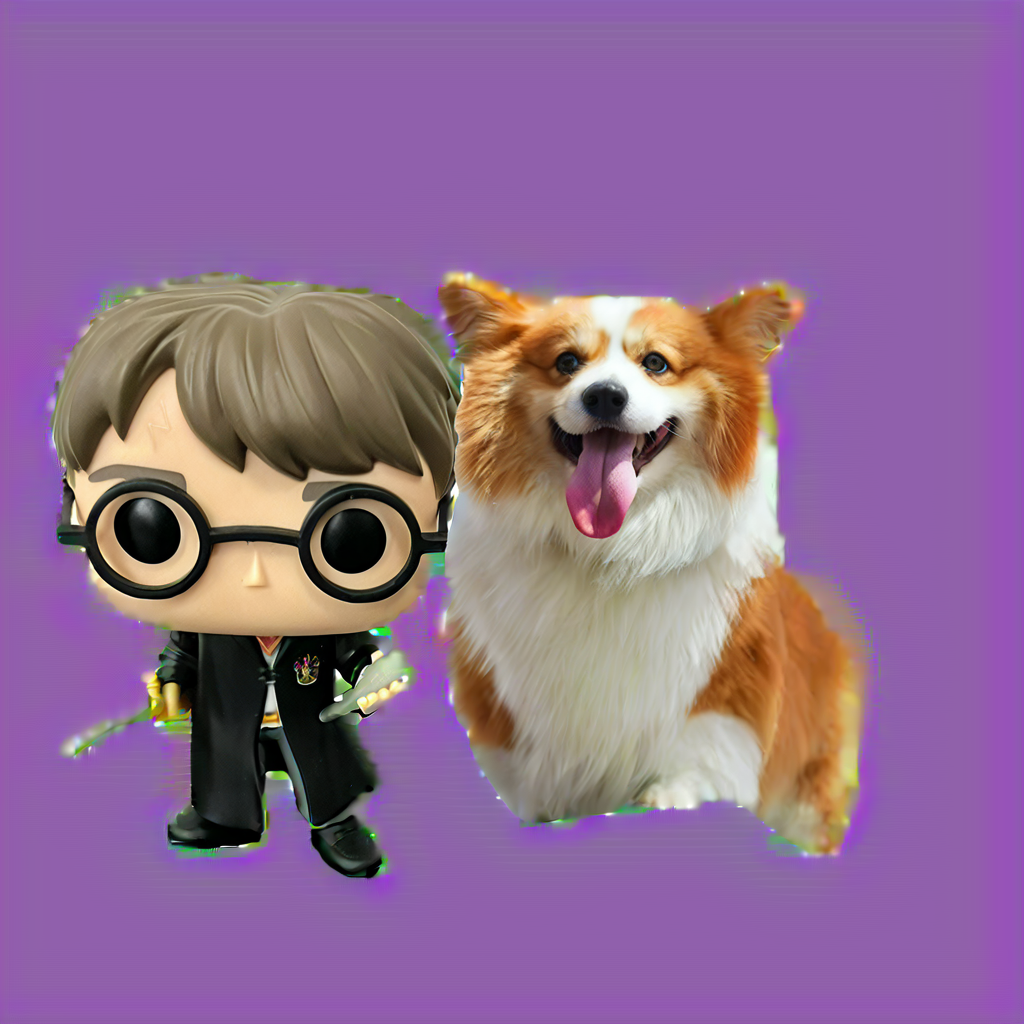

In [6]:
# visualize
with torch.no_grad():
    image = pipe.vae.decode(init_latent, return_dict=False)[0]    
    image = pipe.image_processor.postprocess(image, output_type='pil')
image[0]

In [7]:
pipe.unload_lora_weights()
pipe.load_lora_weights('output/actionfigure_2_and_dog0_name_p0.5_s0_dco/save-1800')

100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


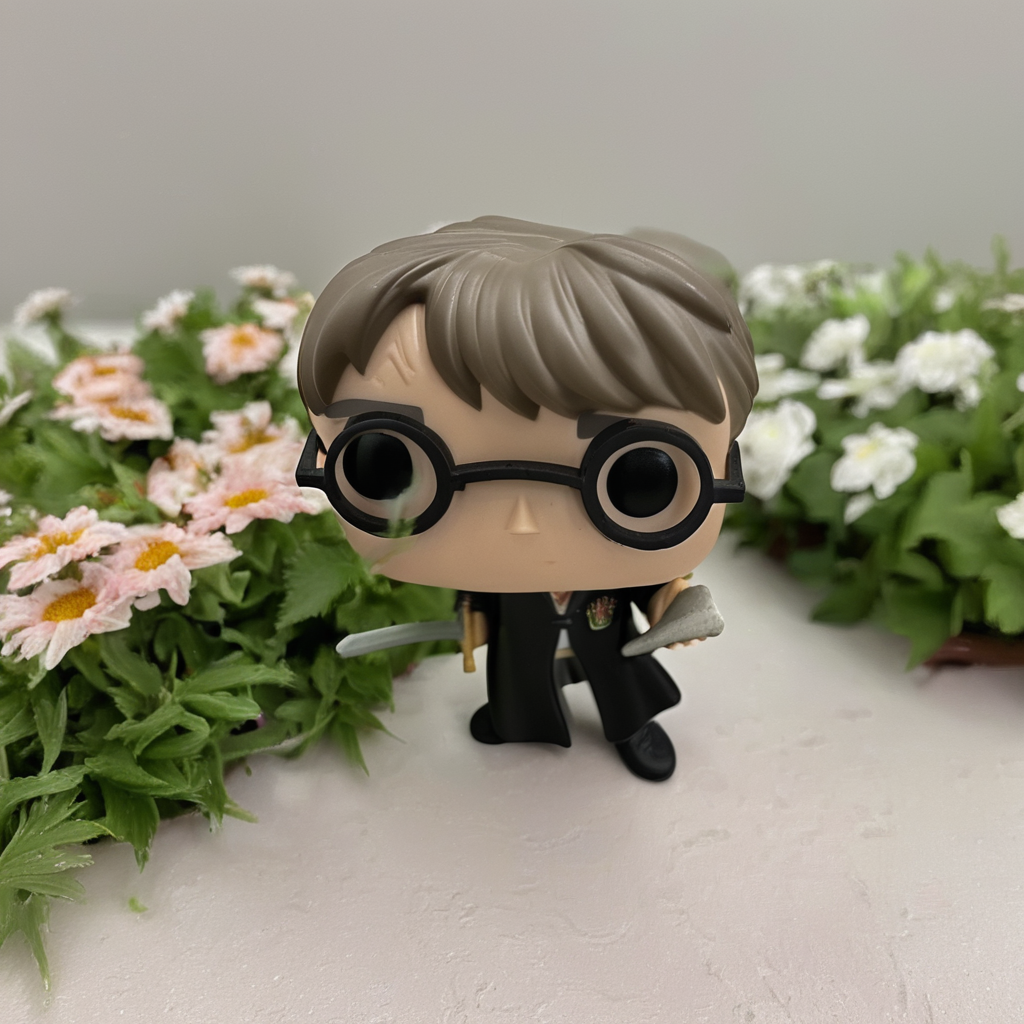

In [8]:
# w/o our Inference
prompt = 'olis harry potter toy and hta corgi in a garden full of flowers. high quality'
negative_prompt = "sticker, collage, anime, cartoon, graphic, text, painting, crayon, graphite, abstract glitch, blurry"
seed = 10
generator = torch.Generator(device=device).manual_seed(seed)

noise = randn_tensor(init_latent.shape, device=pipe.unet.device, dtype=torch.float16, generator=generator)
init_latent_ = noise
img = pipe(prompt=prompt, negative_prompt=negative_prompt, 
           latents=init_latent_, cross_attention_kwargs={'scale': 1}).images[0]
img

100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


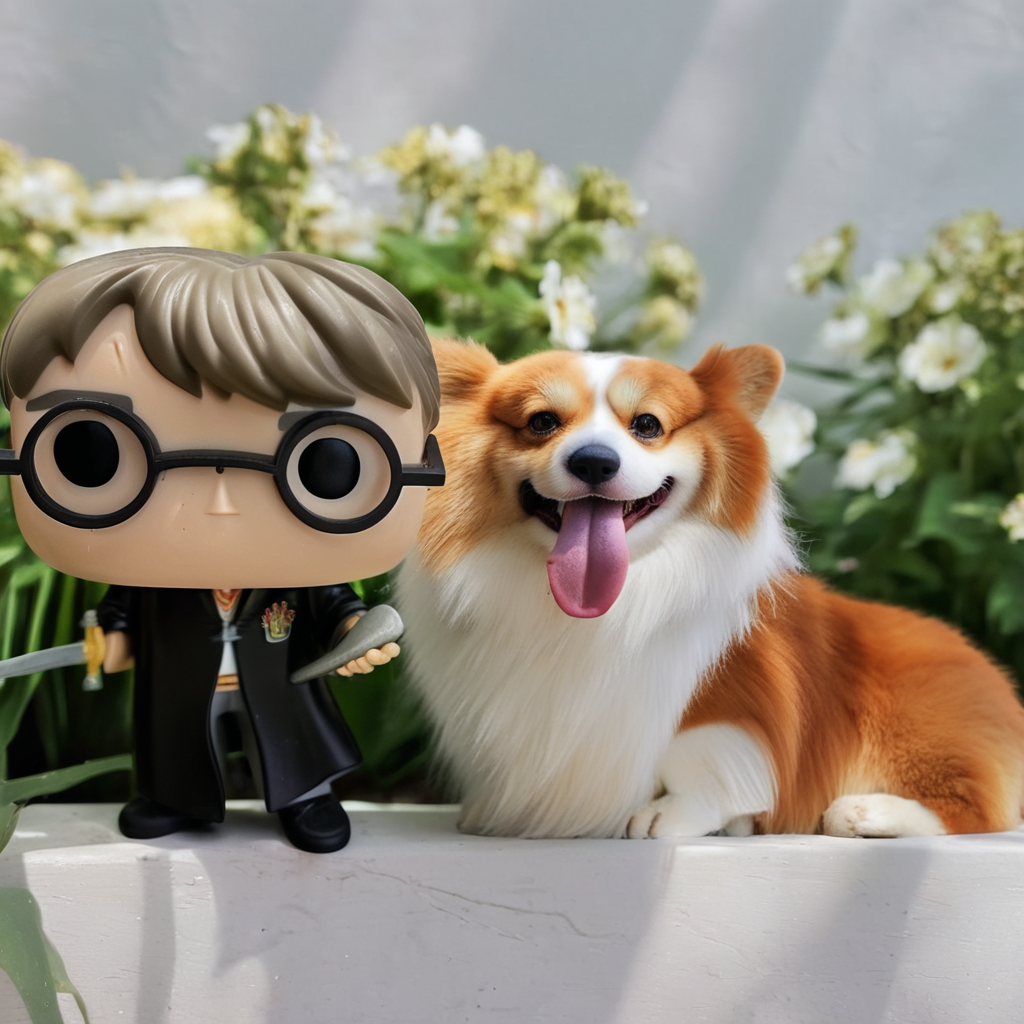

In [9]:
# w/ our Inference
prompt = 'olis harry potter toy and hta corgi in a garden full of flowers. high quality'
negative_prompt = "sticker, collage, anime, cartoon, graphic, text, painting, crayon, graphite, abstract glitch, blurry"
seed = 10
gamma = 1
generator = torch.Generator(device=device).manual_seed(seed)

noise = randn_tensor(init_latent.shape, device=pipe.unet.device, dtype=torch.float16, generator=generator)
init_latent_ = add_noise(pipe, pipe.vae.config.scaling_factor * init_latent * gamma, strength=1., noise=noise)
init_latent_ /= pipe.scheduler.init_noise_sigma

img = pipe(prompt=prompt, negative_prompt=negative_prompt, 
           latents=init_latent_, cross_attention_kwargs={'scale': 1}).images[0]
img